# Basic Visualizations for Football Analytics

Inspired from the lessons from [soccermatics](https://soccermatics.readthedocs.io/en/latest/lesson1/VisualisingFootball.html), in this notebook we look at basic visualizations from football events data where events refer to key actions such as passes, shots, ball carries/recoveries, dribbles, etc. 

Visualizations will be primarily built using the excellent [mplsoccer](https://github.com/andrewRowlinson/mplsoccer/tree/main).

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # Used to add custom legends
from mplsoccer import Pitch
from statsbombpy import sb

# Warning suppressions
import os
import warnings

# For reproducibility
np.random.seed(14)

### A peculiar case of EURO 2024: Spain vs Croatia

Spain were crowned European Champions and were widely regarded as *the best team who have won the tournament*. Yet, in an early group stage game against Croatia, Spain registered a much lower xG (expected goals) than their opponents while recording a convincing final score of a 3-0 win.

Here, we take a look at the match events for a few basic visualizations, thanks to [data released by StatsBomb for free](https://statsbomb.com/news/statsbomb-release-free-euro-2024-data/).

In [2]:
"""
The code snippet below loads events from all matches in EURO 2024 by using `statsbombpy` without any credentials provided. 
Overwrite it with credentials and warnings should not show up every time an API call is made.
Admittedly, the 'catch warning' code is kinda hacky as the usual methods didn't quite suppress the warnings and doesn't make for good reading.
"""

# Filter NoAuthWarning with a context manager
with warnings.catch_warnings():
    os.environ['PYTHONWARNINGS'] = 'ignore'
    warnings.simplefilter(action = 'ignore', category = UserWarning)

    # Specify competition -- id provided by statsbomb
    comp_id = {
        'competition_id': 55,
        'season_id': 282,
    }

    # Fetch competition parameters for downstream usage
    euros_params = (
        sb
        .competitions()
        .loc[
            lambda x: (x.competition_id == comp_id['competition_id']) & (x.season_id == comp_id['season_id'])
        ]
        .to_dict(orient = 'records')[0]
    )

    # Load events
    euro_events = sb.competition_events(
        country = euros_params['country_name'],
        season = euros_params['season_name'],
        gender = euros_params['competition_gender'],
        division = euros_params['competition_name'],
        split = True, # Splits events into seperate dataframes and stored in a dict, denoted by keys such as passes, shots, etc.
    )

In [3]:
# Here, we select Spain vs Croatia's game
euro_matches = sb.matches(**comp_id)
match_id = euro_matches.match_id.sample(random_state = 14).values[0]
display(
    euro_matches
    .loc[
        lambda x: x.match_id == match_id, 
        ['home_team', 'home_score', 'away_score', 'away_team']
    ]
)

,home_team,home_score,away_score,away_team
48,Spain,3,0,Croatia


#### Skill or just pure luck?

It's not always the case where a team would beat their opponent with such a comfortable score despite being outscored in xG. One of the first things to look at naturally would be the shots taken and the goals scored from both teams, along with its xG statistic.

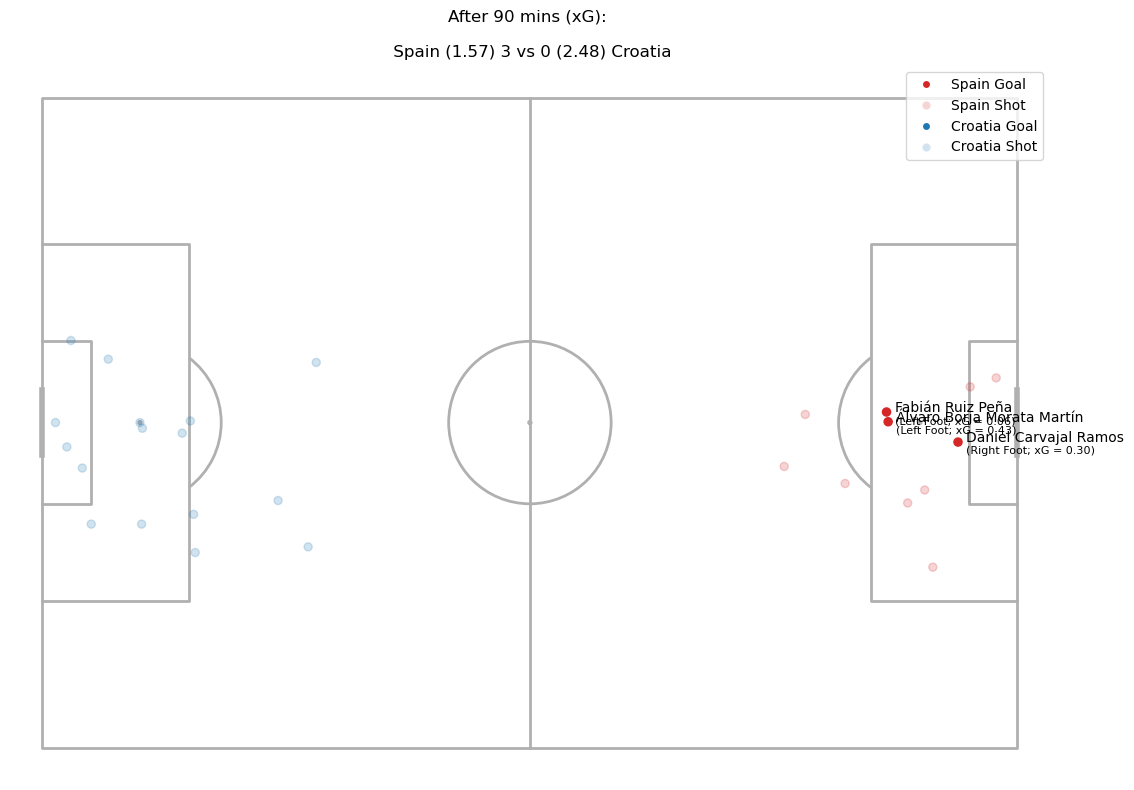

In [4]:
# Shot Map
# Get shots data
shots = euro_events['shots']

# Split location into x, y coordinates
shots['x'], shots['y'] = zip(*list(shots['location'].values))

# Get match shots up to 90 mins
match_shots = (
    shots
    .loc[lambda x: (x.match_id == match_id) & (x.period <= 2)]
    .copy()
)

# Plot Pitch
pitch = Pitch() # Initialize pitch object
fig, ax = pitch.draw(figsize=(12, 8)) # Create fig, axes

# Define pitch size and playing teams
pitchLengthX = 120 # in yards
pitchWidthY = 80
team1, team2 = match_shots.possession_team.unique().tolist()
g1, g2 = 0, 0

# Iterate through all shots
for i, shot in match_shots.iterrows():
    # Get shot attributes
    x = shot['x']
    y = shot['y']
    team_name = shot['team']
    outcome = shot['shot_outcome']
    xg = shot['shot_statsbomb_xg']
    player = shot['player']
    body_part = shot['shot_body_part']

    # Set circle size and alpha level
    rad = 0.5
    alpha = 0.2
    colors = ('tab:red', 'tab:blue')

    if team_name == team1:
        # If goal, add name, else lower color alpha
        if outcome == 'Goal':
            shotCircle = plt.Circle((x, y), radius = rad, color = colors[0])
            plt.text(x+1, y, player, fontsize = 10)
            plt.text(x+1, y + 1.5, '({}; xG = {:.2f})'.format(body_part, xg), fontsize = 8)
            g1+=1
        else:
            shotCircle = plt.Circle((x, y), radius = rad, color = colors[0])
            shotCircle.set_alpha(alpha)
    
    # Repeat for other team but flip positions and color
    if team_name == team2:
        # If goal, add name, else lower color alpha
        if outcome == 'Goal':
            shotCircle = plt.Circle((pitchLengthX - x, pitchWidthY - y), radius = rad, color = colors[1])
            plt.text(pitchLengthX - x + 1, pitchWidthY - y - 2, player, fontsize = 10)
            plt.text(pitchLengthX - x + 1, pitchWidthY - y - 2 + 1.5, '({}; xG = {:.2f})'.format(body_part, xg), fontsize = 8)
            g2+=1
        else:
            shotCircle = plt.Circle((pitchLengthX - x, pitchWidthY - y), radius = rad, color = colors[1])
            shotCircle.set_alpha(alpha)

    # Add it to axes
    ax.add_patch(shotCircle)
            
# Add title with xG
try:
    expected_goals = (
        match_shots
        .groupby('team')
        .shot_statsbomb_xg
        .sum()
        .to_dict()
    )
    xg1, xg2 = expected_goals[team1], expected_goals[team2]
    plt.title('After 90 mins (xG): \n\n {} ({:.2f}) {} vs {} ({:.2f}) {}'.format(team1, xg1, g1, g2, xg2, team2,))
except:
    plt.title('After 90 mins: \n\n {} vs {}'.format(team1, team2))

# Create legend by using markers
marker1 = Line2D([], [], color="white", marker='o', markerfacecolor = colors[0])
marker2 = Line2D([], [], color="white", marker='o', markerfacecolor = colors[1])
marker3 = Line2D([], [], color="white", marker='o', markerfacecolor = colors[0], alpha = alpha)
marker4 = Line2D([], [], color="white", marker='o', markerfacecolor = colors[1], alpha = alpha)

# Add legend with score and xG
plt.legend((marker1, marker3, marker2, marker4), ('{} Goal'.format(team1), '{} Shot'.format(team1), '{} Goal'.format(team2), '{} Shot'.format(team2)), loc = 1)

# More settings
plt.show()

We can see all 3 goals were scored in the centre of the pitch, consistent with the wisdom (*validated by data*) that goals primarily come from shots taken in the middle area. More importantly, if we look a little closer at its xG (*Ruiz's information overlaps with Morata's - something to be improved on later*), we see that Fabian Ruiz's goal was rated at a 6% chance of scoring from the given context - this was the opening goal of the game that was a sucker-punch for the Croats as they were the ones creating the chances mainly.

Croatia did take several shots with quite a few in the six-yard box, which led to a high xG score, but failed to convert any of them. Would having a lethal striker like [Mario Mandžukić](https://en.wikipedia.org/wiki/Mario_Mand%C5%BEuki%C4%87) of the olden days helped to convert some of these chances? 

*Perhaps*.

#### Midfield Maestros

The game also presented some of the best central midfielders that the game has to offer in the legendary Real Madrid's Luka Modrić, City's Rodri (widely regarded as the best defensive midfielder in the world currently) and PSG's Fabián Ruiz (who turned out to be one of the best players in the tournament). These maestros typically serve as the heartbeat of their respective teams being at the centre of everything. Below, we take a look at their passes from the game.

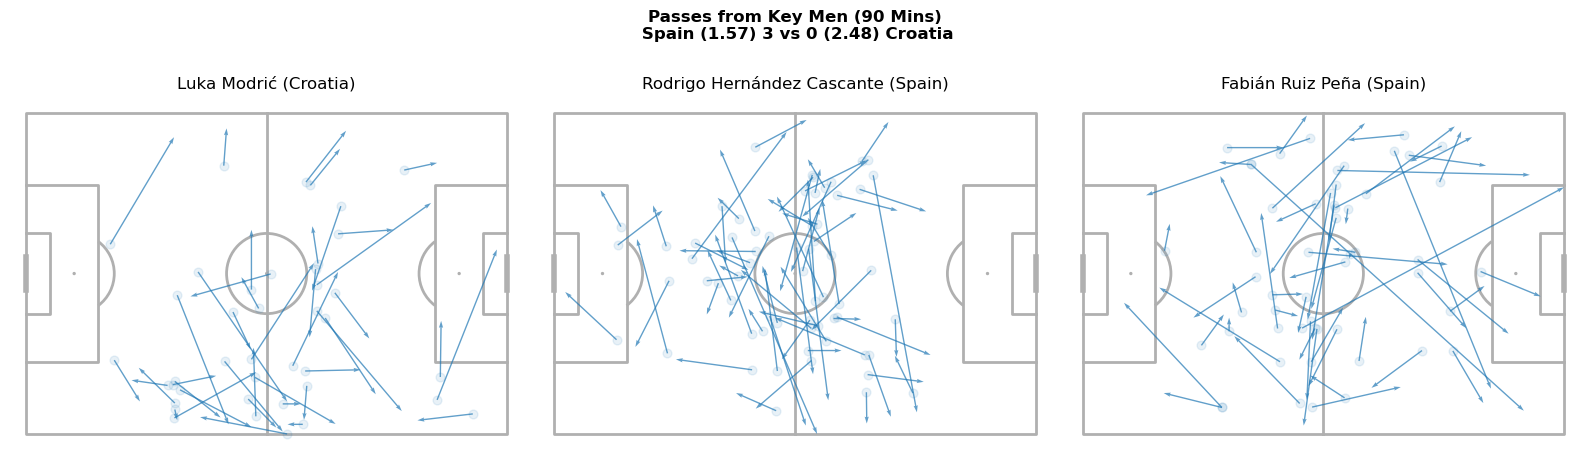

In [5]:
# Pass Map
# Get pass data
passes = (
    euro_events['passes']
    .loc[lambda x: (x.match_id == match_id) & (x.period <= 2)]
    .assign(
        start_x = lambda x: np.array(x.location.values.tolist())[:, 0],
        start_y = lambda x: np.array(x.location.values.tolist())[:, 1],
        end_x = lambda x: np.array(x.pass_end_location.values.tolist())[:, 0],
        end_y = lambda x: np.array(x.pass_end_location.values.tolist())[:, 1],
    )
)

# Specify player(s) or team to analyze
players = ['Modric', 'Rodri', 'Ruiz']

# Initialize pitch
pitch = Pitch()
fig, axs = pitch.draw(nrows = 1, ncols = len(players), figsize = (16, 5))

# Loop through every player
for player, ax in zip(players, axs):
    # Get player passes
    player_passes = (
        passes
        .loc[
            lambda x: 
            (
                x
                # Remove all tone accents
                .player.str.normalize('NFKD')
                .str.encode('ascii', errors = 'ignore')
                .str.decode('utf-8')

                # Get player's passes
                .str.lower()
                .str.contains(player.lower())
            )
        ]
    )

    # Plot pass start/end locations
    pitch.scatter(player_passes.start_x, player_passes.start_y, alpha = 0.1, s = 40, color = 'tab:blue', ax = ax)
    pitch.arrows(player_passes.start_x, player_passes.start_y, player_passes.end_x, player_passes.end_y, color = 'tab:blue', ax = ax, width = 1, alpha = 0.7)

    # Set title as player name
    ax.set_title('{} ({})'.format(player_passes.player.unique()[0], player_passes.team.unique()[0]))

# Settings
fig.suptitle('Passes from Key Men (90 Mins)\n {} ({:.2f}) {} vs {} ({:.2f}) {}'.format(team1, xg1, g1, g2, xg2, team2,), size = 12, fontweight = 'bold', x = 0.5)
plt.show()

Modrić didn't quite play enough final third passes to create dangereous chances for his team and that could be down to tactics from Spain to stop the maestro from doing so as part of their game plan. 

Rodri's passes were observed to be much safer, mostly going sideways that were played closer around his team's own goal, which is sensible since losing possession in their own half would be a danger and Rodri's main job was to keep ball and play out of any pressure from Croatia. Ruiz's passing contrasted from Rodri as he was much more adventurous and getting into final third positions to make killer passes to Yamal, Williams and Morata, where one of them led to Morata's goal.

#### Connections and Passages

Spain has been reknowned for their ability to pass as a team playing [decentralized football](https://soccermatics.readthedocs.io/en/latest/lesson1/passnetworksExample.html) where everyone in the team is involved instead of relying on moments from one or two players. Here, we take a look at passing networks from both teams that sheds a little more light about its patterns of play.

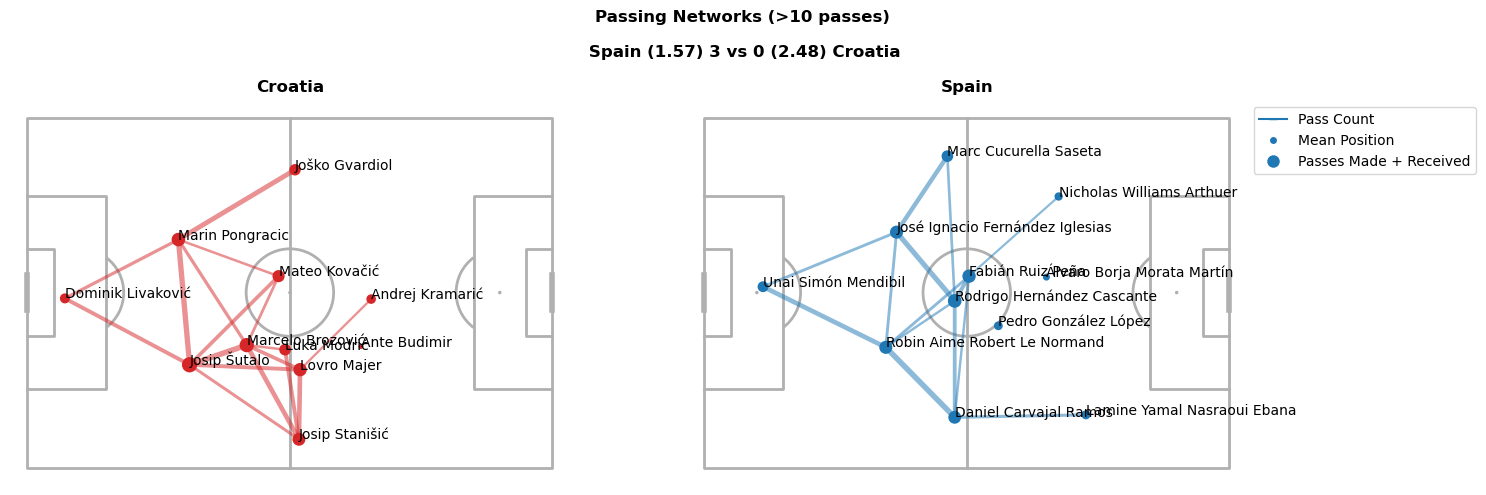

In [6]:
# Pass Network
# Get successful passes from first XI
starters = [
    players['player']['name']
    for team_xi in euro_events['starting_xis'].loc[lambda x: x.match_id == match_id, 'tactics'].values
    for players in team_xi['lineup']
]
passes = (
    euro_events['passes']
    .loc[lambda x: (x.match_id == match_id) & (x.period <= 2) & (x.pass_outcome.isnull()) & (x.player.isin(starters)) & ((x.pass_recipient.isin(starters)))]
    .assign(
        start_x = lambda x: np.array(x.location.values.tolist())[:, 0],
        start_y = lambda x: np.array(x.location.values.tolist())[:, 1],
        end_x = lambda x: np.array(x.pass_end_location.values.tolist())[:, 0],
        end_y = lambda x: np.array(x.pass_end_location.values.tolist())[:, 1],
    )
)

# Calculate each player's average positions, total passes and node size
df1 = passes.loc[:, ['player', 'team', 'start_x', 'start_y']].rename({'start_x': 'x', 'start_y': 'y'}, axis = 1).reset_index(drop = True).copy()
df2 = passes.loc[:, ['pass_recipient', 'team', 'end_x', 'end_y']].rename({'pass_recipient': 'player', 'end_x': 'x', 'end_y': 'y'}, axis = 1).reset_index(drop = True).copy()
mean_positions = (
    pd
    .concat([df1, df2], ignore_index = True)
    .groupby(['player', 'team'])
    .agg({'x' : 'mean', 'y': 'mean', 'team': 'size'})
    .rename({'team':'passes'}, axis = 1)
    .reset_index()
    .assign(
        marker_size = lambda x: (x.passes / x.passes.max()) * 100,
        # color = lambda x: x.apply(lambda y: 'tab:blue' if y.team == 'Croatia' else 'tab:red', axis = 1)
    ) 
)

# Calculate edge width, i.e. number of passes between each player
pair_passes = (
    passes
    .loc[:, ['player', 'team', 'pass_recipient']]
    .assign(
        pass_pair = lambda x: x.apply(lambda y: 
            '{} - {}'.format(*sorted([y.player, y.pass_recipient])), axis = 1 # Sorting is required if direction is ignored
        )
    )
    .groupby(['pass_pair', 'team'])
    .size()
    .loc[lambda x: x >= 10]
    .sort_values(ascending = False)
    .reset_index(name = 'pass_count')
)

# Initialize pitch
pitch = Pitch()
fig, axs = pitch.draw(nrows = 1, ncols = 2, figsize = (16, 5))

# Draw player nodes
teams = ['Croatia', 'Spain']
colors = ['tab:red', 'tab:blue']
for team, ax, color in zip(teams, axs, colors):
    # Draw nodes
    team_positions = mean_positions.loc[lambda x: x.team == team].copy()
    pitch.scatter(team_positions.x, team_positions.y, s = team_positions.marker_size, color = color, ax = ax)
    
    # Annotate names
    for i, row in team_positions.iterrows():
        pitch.annotate(row.player, xy = (row.x, row.y), c = 'black', ax = ax)

    # Draw edges
    for i, row in pair_passes.loc[lambda x: x.team == team].iterrows():
        # Get attributes of each pass
        p1, p2 = row['pass_pair'].split(' - ')
        p1_x, p1_y = team_positions.loc[lambda x: x.player == p1, ['x', 'y']].values[0]
        p2_x, p2_y = team_positions.loc[lambda x: x.player == p2, ['x', 'y']].values[0]

        # Get line width
        width = row['pass_count'] / pair_passes.loc[lambda x: x.team == team, 'pass_count'].max() * 4

        # Plot edges
        pitch.lines(p1_x, p1_y, p2_x, p2_y, alpha = 0.5, lw = width, zorder = 2, color = color, ax = ax)

    # Set title
    ax.set_title('{}'.format(team), fontweight = 'bold')

# Add legend
marker1 = Line2D([], [], color=colors[1], marker='_', markerfacecolor = 'white')
marker2 = Line2D([], [], color="white", marker='o', markerfacecolor = colors[1])
marker3 = Line2D([], [], color="white", marker='o', markerfacecolor = colors[1], markersize = 10)
plt.legend([marker1, marker2, marker3], ['Pass Count', 'Mean Position', 'Passes Made + Received'], bbox_to_anchor = (1, 1))

# Other settings
fig.suptitle('Passing Networks (>10 passes)\n\n {} ({:.2f}) {} vs {} ({:.2f}) {}'.format(team1, xg1, g1, g2, xg2, team2,), fontweight = 'bold')
plt.show()

Croatia focused their play on the central-right areas with legendary midfield trio Kovačić, Brozović and Modrić playing short passes between them and forwards Kramarić, Majer and Budimir staying narrow. The lack of passing connections from the wing backs/midfielders to the forwards (*especially from the left*) exhibits Spain's pivot strength in Rodri and Ruiz preventing line-breaking passes. 

Spain went forward mostly through their wide men in the excellent Nico Williams and wonderkid Lamine Yamal, who were some of the superstars of the tournament. One area of improvement could be Pedri's connections with the pivots and striker Morata as he didn't seem to have received or played many passes with anyone in the game which may have been slipped past attention because of the brilliance from the wingmen and a convincing scoreline.

#### Shoot where it matters

Croatia played with narrow forwards and Spain with inverted wingers might be a data-driven decision to get players into shooting positions (i.e *central areas, nearer to goal*) that produce better scoring rates. In both teams, shooting almost always happens centrally and frequency increases within the penalty box.

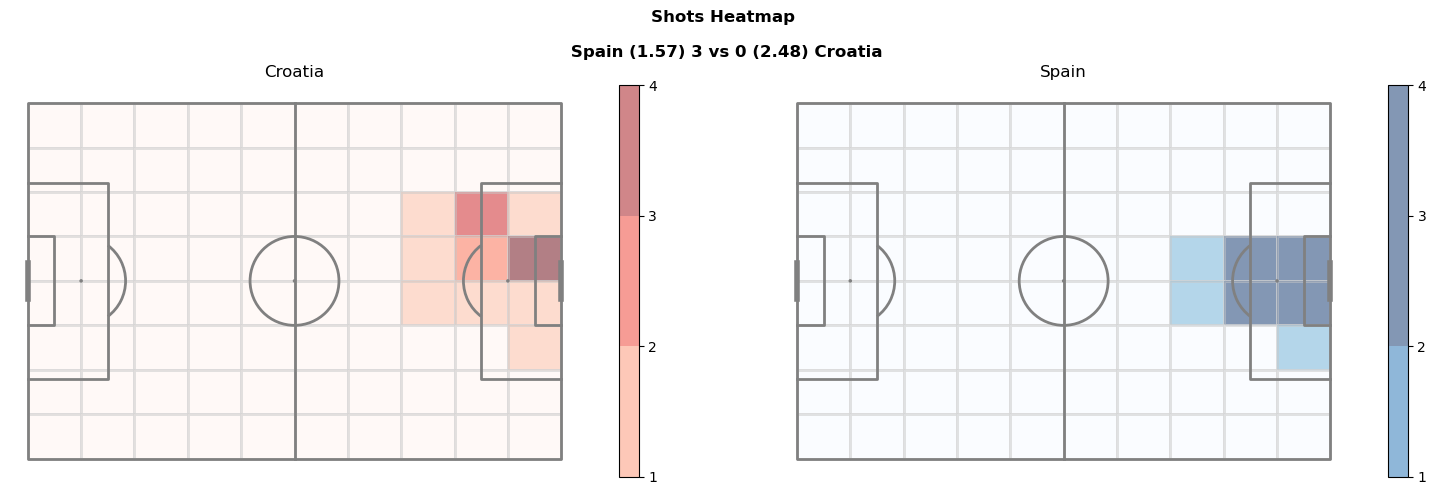

In [48]:
# Shots Heatmap (histogram)
# Initialize pitch
pitch = Pitch(
    line_zorder = 2, # Adds lines to the pitch
    line_color = 'grey',
)
fig, axs = pitch.draw(nrows = 1, ncols = 2, figsize = (16, 5))

# Plot heatmaps
teams = ['Croatia', 'Spain']
colors = ['Reds', 'Blues']
for team, color, ax in zip(teams, colors, axs):
    # Get team data
    data = (
        match_shots
        .loc[lambda x: x.team == team]
        .copy()
    )

    # Create statistic
    bins = pitch.bin_statistic(data.x, data.y, statistic = 'count', bins = (10, 8))

    # Make heatmap
    heatmap = pitch.heatmap(bins, cmap = color, ax = ax, edgecolor = 'lightgrey', alpha = 0.5)

    # Add colorbar for scale
    cbar = plt.colorbar(heatmap, boundaries = np.arange(start = 1, stop = 4+1))

    # Add title
    ax.set_title(team)
    
# Other settings
fig.suptitle('Shots Heatmap\n\n {} ({:.2f}) {} vs {} ({:.2f}) {}'.format(team1, xg1, g1, g2, xg2, team2,), fontweight = 'bold')
plt.show()
